In [ ]:
import copy

import os
import datetime
import pathlib
from google.colab import drive

import matplotlib.pyplot as plt
import PIL
from PIL import Image
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm, trange

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.model_selection import train_test_split

path = '/content/drive/MyDrive/Colab Notebooks/Satellite Image Classification/'

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [ ]:
epoch_num = 1
batch_size = 64
img_height = 256
img_width = img_height

#Load dataset

In [ ]:
drive.mount('/content/drive')
data_dir = pathlib.Path(path)

Mounted at /content/drive


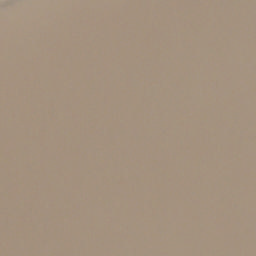

In [ ]:
cloudy = list(data_dir.glob('cloudy/*'))
cmyk = Image.open(cloudy[0])
rgb = cmyk.convert("RGB")
rgb

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize((img_width, img_height), antialias=True),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

ds = torchvision.datasets.ImageFolder(path, transform=transform)

image_count = len(ds)
train_size = int(image_count * 0.7)
test_size = image_count - train_size
print(f"Всего изображений: {image_count}, тестовая выборка: {test_size}, обучающая выборка: {train_size}")
train_set, val_set = torch.utils.data.random_split(ds, [train_size, test_size])
trainloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(val_set, batch_size=batch_size,
                                         shuffle=False, num_workers=2)
classes = ds.find_classes(path)[0]
print(classes)

Всего изображений: 5631, тестовая выборка: 1690, обучающая выборка: 3941
['cloudy', 'desert', 'green_area', 'water']


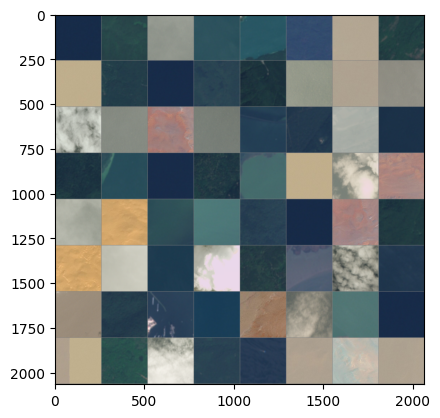

water green_area cloudy water water green_area desert green_area desert green_area water green_area green_area cloudy desert cloudy cloudy cloudy desert cloudy water green_area cloudy water green_area water water green_area water desert cloudy desert cloudy desert water water green_area water desert green_area desert cloudy water cloudy green_area water cloudy water cloudy green_area water water desert cloudy water water desert green_area cloudy green_area water desert desert desert


In [ ]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

#NN class and additional functions

In [ ]:
class Net(nn.Module):
    def __init__(self, num_conv_layers=2, conv_num=(6, 10), conv_size=(5, 5), 
                 maxpool_size=(2, 2), num_linear_layers=2, linear_size=(120, 84),
                 act_function='relu'):
        super().__init__()
        im_size = img_width

        self.act_function = None
        if act_function == 'relu':
            self.act_function = F.relu
        elif act_function == 'sigmoid':
            self.act_function = F.sigmoid
        elif act_function == 'tanh':
            self.act_function = F.tanh
        elif act_function == 'leaky_relu':
            self.act_function = F.leaky_relu
        
        self.conv = [nn.Conv2d(3, conv_num[0], conv_size[0])]
        self.add_module(f"cov{0}", self.conv[-1])

        self.pool = [nn.MaxPool2d(maxpool_size[0], maxpool_size[0])]
        self.add_module(f"pool{0}", self.pool[-1])

        im_size = (im_size - 2 * (conv_size[0] // 2)) // maxpool_size[0]

        for i in range(1, num_conv_layers):
            self.conv += [nn.Conv2d(conv_num[i-1], conv_num[i], conv_size[i])]
            self.add_module(f"cov{i}", self.conv[-1])

            self.pool += [nn.MaxPool2d(maxpool_size[i], maxpool_size[i])]
            self.add_module(f"pool{i}", self.pool[-1])

            im_size = (im_size - 2 * (conv_size[i] // 2)) // maxpool_size[i]
        
        self.linear = [nn.Linear(conv_num[-1] * (im_size ** 2), linear_size[0])]
        self.add_module(f"linear{0}", self.linear[-1])

        for i in range(1, num_linear_layers):
            self.linear += [nn.Linear(linear_size[i-1], linear_size[i])]
            self.add_module(f"linear{i}", self.linear[-1])
        
        self.fc_out = nn.Linear(linear_size[-1], 4)


    def forward(self, x):
        for conv, pool in zip(self.conv, self.pool):
            x = pool(self.act_function(conv(x)))
        x = torch.flatten(x, 1)
        for lin in self.linear:
            x = self.act_function(lin(x))
        x = self.fc_out(x)
        return x

    def backward(self, traindata, verbose=True):
        running_loss = 0.0
        batch_bar = tqdm(traindata, leave=True, disable=(not verbose))
        for i, data in enumerate(batch_bar, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()

            outputs = self(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            # batch_bar.set_description_str(f"Epoch {epoch+1}")
            batch_bar.set_postfix(mse=float(loss))
        return running_loss

    def train(self, data, epoch_num, verbose=True):
        epoch_bar = trange(epoch_num, disable=(not verbose))

        for epoch in epoch_bar:
            loss = self.backward(data, verbose)
        epoch_bar.set_postfix(mse=float(loss))

In [ ]:
def init_weights_uniform(module):
    if type(module) == nn.Linear or type(module) == nn.Conv2d:
        nn.init.uniform_(module.weight)

def init_weights_normal(module):
    if type(module) == nn.Linear or type(module) == nn.Conv2d:
        nn.init.normal_(module.weight)

def init_weights_orthogonal(module):
    if type(module) == nn.Linear or type(module) == nn.Conv2d:
        nn.init.orthogonal_(module.weight)
        
def init_weights_kaiming_uniform(module):
    if type(module) == nn.Linear or type(module) == nn.Conv2d:
        nn.init.kaiming_uniform_(module.weight)

def init_weights_kaiming_normal(module):
    if type(module) == nn.Linear or type(module) == nn.Conv2d:
        nn.init.kaiming_normal_(module.weight)

In [ ]:
def net_accuracy(net, data_loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct // total

In [ ]:
def train(net, epoch_num, verbose=True):
    epoch_bar = trange(epoch_num, disable=(not verbose),)

    for epoch in epoch_bar:
        running_loss = 0.0
        batch_bar = tqdm(trainloader, leave=True, disable=(not verbose))
        for i, data in enumerate(batch_bar, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            batch_bar.set_description_str(f"Epoch {epoch+1}")
            batch_bar.set_postfix(mse=float(loss))

        epoch_bar.set_postfix(mse=float(loss))

In [ ]:
net = Net()
net.to(device)
net.apply(init_weights_uniform)

Net(
  (cov0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cov1): Conv2d(6, 10, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear0): Linear(in_features=37210, out_features=120, bias=True)
  (linear1): Linear(in_features=120, out_features=84, bias=True)
  (fc_out): Linear(in_features=84, out_features=4, bias=True)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
# optimizer = optim.Adam(net.parameters(), lr=0.001)

In [ ]:
# train(net, 1, verbose=False)
net.train(trainloader, 2)
print('Finished Training')

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
def nn_classifier(num_conv_layers=2, conv_num=(6, 10), conv_size=(5, 5), 
                 maxpool_size=(2, 2), num_linear_layers=2, linear_size=(120, 84),
                 act_function='relu', weight_init='uniform', optimizer_type='sgd', epoch_num=1, verbose=True):
    net = Net(num_conv_layers, conv_num, conv_size, 
                 maxpool_size, num_linear_layers, linear_size,
                 act_function)
    net.to(device)
    if weight_init == 'uniform':
        net.apply(init_weights_uniform)
    elif weight_init == 'normal':
        net.apply(init_weights_normal)
    elif weight_init == 'orthogonal':
        net.apply(init_weights_orthogonal)
    elif weight_init == 'kaiming_uniform':
        net.apply(init_weights_kaiming_uniform)
    elif weight_init == 'kaiming_normal':
        net.apply(init_weights_kaiming_normal)

    if optimizer_type == 'sgd':
        optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
    elif optimizer_type == 'adam':
        optimizer = optim.Adam(net.parameters(), lr=0.001)
    train(net, epoch_num, verbose)
    res = net_accuracy(net, testloader)
    if verbose:
        print(res)
    return res

# nn_classifier()

#Genetic algorithm

In [ ]:
'''
16 16 16 16 4  4  4  4  1  1  1  1  4  4  4  4  2  2  1
4  8  12 16 18 20 22 24 25 26 27 28 32 36 40 44 46 48 49
'''

'\n16 16 16 16 4  4  4  4  1  1  1  1  4  4  4  4  2  2  1\n4  8  12 16 18 20 22 24 25 26 27 28 32 36 40 44 46 48 49\n'

In [ ]:
def decoding(gen):
    gen = ''.join([str(i) for i in gen])
    par = {
            'num_conv_layers': 0, 
            'conv_num': (int(gen[0:4], 2), 
                         int(gen[4:8], 2), 
                         int(gen[8:12], 2), 
                         int(gen[12:16], 2)),
            'conv_size': (3+int(gen[16:18], 2), 
                          3+int(gen[18:20], 2), 
                          3+int(gen[20:22], 2), 
                          3+int(gen[22:24], 2)), 
            'maxpool_size': (2+int(gen[24:25], 2), 
                             2+int(gen[25:26], 2), 
                             2+int(gen[26:27], 2), 
                             2+int(gen[27:28], 2)), 
            'num_linear_layers': 2, 
            'linear_size': (10*int(gen[28:32], 2), 
                            10*int(gen[32:36], 2), 
                            10*int(gen[36:40], 2), 
                            10*int(gen[40:44], 2)),
            'act_function': ['relu', 
                             'sigmoid', 
                             'tanh', 
                             'leaky_relu'][int(gen[44:46], 2)], 
            'weight_init': ['uniform', 
                            'normal', 
                            'kaiming_uniform', 
                            'kaiming_normal'][int(gen[46:48], 2)], 
            'optimizer_type': ['sgd', 'adam'][int(gen[48:49], 2)],
            }
            
    par['conv_size'] = tuple(b for a, b in zip(par['conv_num'], par['conv_size']) if a > 0)
    par['maxpool_size'] = tuple(b for a, b in zip(par['conv_num'], par['maxpool_size']) if a > 0)
    par['conv_num'] = tuple((a for a in par['conv_num'] if a > 0))
    par['num_conv_layers'] = len(par['conv_num'])

    par['linear_size'] = tuple((a for a in par['linear_size'] if a > 0))
    par['num_linear_layers'] = len(par['linear_size'])

    return par

# g = np.random.default_rng().integers(2, size=(49))
# print(*g)
# decoding(g)

In [ ]:
def sphere_func(x):
    return np.power(x[0], 2) + np.power(x[1], 2)


def bin_decode(binary, variables, chromosome_size, step, l_boundary):
    return np.sum(binary * np.power(2 * np.ones((variables, chromosome_size)), np.arange(chromosome_size)), axis=2) * step + l_boundary


class GeneticAlgorithm:

    def __init__(self,
                 f=sphere_func,
                 boundary=(-5, 5),
                 step=0.01,
                 variables=2,
                 population_size=50,
                 type='min',
                 generation_num=10,
                 elite_num=2,
                 mutation_prob=0.01,
                 decode_fun=bin_decode,
                 verbose=True
                 ):
        self.f = f
        self.boundary = boundary
        self.variables = variables
        self.population_size = population_size
        self.type = type
        self.generation_num = generation_num
        self.elite_num = elite_num
        self.mutation_prob = mutation_prob
        self.chromosome_size = int(
            np.ceil(np.log2((boundary[1] - boundary[0]) / step)))
        # self.step = step
        self.step = (boundary[1] - boundary[0]) / (2 ** self.chromosome_size)
        self.decode_fun = decode_fun
        rng = np.random.default_rng()

        self.population = rng.integers(
            2, size=(population_size, variables, self.chromosome_size))

        self.history = {
            'best_fit': [],
            'best_fenotype': [],
            'best_value': [],
            'average_fit': [],
            'populations': [self.population],
            'generation': [0],
            'fenotypes': [],
            'fitness': []
        }
        self.verbose = True
        self.generation = 0
        self.calc_fitness()

    def calc_fitness(self):
        self.fenotypes = []
        pbar = trange(self.population_size, disable=(not self.verbose))
        pbar.set_description('Decoding...')
        for i in pbar:
            self.fenotypes += [decoding(self.population[i, 0])]

        self.fitness = []
        pbar = trange(self.population_size, disable=(not self.verbose))
        pbar.set_description('Evaluating...')
        for i in pbar:
            self.fitness += [nn_classifier(**self.fenotypes[i])]
        
        # self.fitness = self.f([self.fenotypes[:,  i]
        #                       for i in range(self.variables)])
        # if self.type == 'max':
        #     self.fitness_score = np.max(self.fitness) - self.fitness
        # else:
        #     self.fitness_score = self.fitness
        # self.adjusted_fitness = 1 / (1 + self.fitness_score)
        # self.normalized_fitness = self.adjusted_fitness / \
        #     np.sum(self.adjusted_fitness)
        # bn = np.argmax(self.fitness_score)
        # self.history['best_fit'] += [self.adjusted_fitness[bn]]
        # self.history['best_fenotype'] += [self.fenotypes[bn]]
        # self.history['best_value'] += [self.fitness[bn]]
        # self.history['average_fit'] += [self.adjusted_fitness.mean()]
        # self.history['fenotypes'] += [self.fenotypes]
        # self.history['fitness'] += [self.adjusted_fitness]

    def next_generation(self):
        elite = np.argpartition(
            self.adjusted_fitness, -self.elite_num)[-self.elite_num:]
        new_population = self.population[elite]

        parents = np.random.choice(range(
            0, self.population_size), 2 * (self.population_size - self.elite_num), p=self.normalized_fitness)

        crossover_points = np.random.randint(
            1, self.chromosome_size, (self.population_size - self.elite_num))

        for i, cp in enumerate(crossover_points):
            p1 = self.population[parents[2 * i]]
            p2 = self.population[parents[2 * i + 1]]
            ch = np.concatenate((p1[:, :cp], p2[:, cp:]), axis=1)

            mut_prob = [
                np.random.random() < self.mutation_prob for i in range(self.chromosome_size)]
            np.logical_not(ch.astype(bool), where=mut_prob, out=ch)

            new_population = np.concatenate((new_population, [ch.astype(int)]))

        self.population = new_population
        self.generation += 1
        self.history['generation'] += [self.generation]
        self.calc_fitness()

    def optimize(self):
        for g in range(self.generation_num):
            self.next_generation()
            print(
                f"Generation: {self.generation}\t Best fit: {self.history['best_fit'][-1]:.4f}",
                f"with value: {self.history['best_value'][-1]:.4f} at ({self.history['best_fenotype'][-1]})")


ga = GeneticAlgorithm(f=nn_classifier, boundary=(0, 2**49), population_size=2, generation_num=1, mutation_prob=0.1, step=1, variables=1, type='max', verbose=True)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/986 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the 

26


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/986 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the 

32


In [ ]:
ga = GeneticAlgorithm(f=nn_classifier, boundary=(0, 2**49), generation_num=1, mutation_prob=0.1, step=1, variables=1, type='max', verbose=True)

Decoding...


  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
PATH = './res'
torch.save(net.state_dict(), PATH)

/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the 

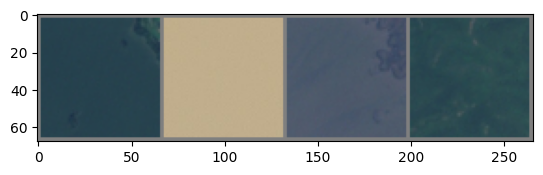

Истинные классы:  water desert water green_area


In [ ]:
dataiter = iter(testloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print('Истинные классы: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [ ]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [ ]:
outputs = net(images)

In [ ]:
_, predicted = torch.max(outputs, 1)

print('Предсказанные:', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Предсказанные: water water water water


In [ ]:
net_accuracy(net, testloader)

/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the 

51

In [ ]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Точность для класса {classname:5s}: {accuracy:.1f} %')

/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the 

Точность для класса cloudy: 93.6 %
Точность для класса desert: 0.0 %
Точность для класса green_area: 99.6 %
Точность для класса water: 0.0 %
